# Support dataset

Move this notebook to the root directory to run it

In [1]:
import os

import numpy as np
# import torch
import argparse
import sys
import pickle
import pandas as pd
from lifelines import CoxPHFitter
import torchtuples as tt
import yaml 
from lifelines.utils import concordance_index
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pathlib import Path
from copy import deepcopy

from coxkan import CoxKAN
from coxkan.datasets import gbsg, metabric, support, nwtco, flchain
from coxkan.utils import FastCoxLoss, count_parameters, bootstrap_metric, set_seed

SEED = set_seed(42)
exp_name = 'support'
results = {'CoxKAN': {}, 'CoxPH': {}}

output_dir = Path('checkpoints') / exp_name
output_dir.mkdir(parents=True, exist_ok=True)

# load dataset
df_train, df_test = support.load(split=True)
dataset_name, duration_col, event_col, covariates = support.metadata()
assert dataset_name == exp_name
print(os.getcwd())
with open(f'./configs/coxkan/{exp_name}.yml', 'r') as f:
    config = yaml.safe_load(f)

with open(output_dir / 'config.yml', 'w') as f:
    yaml.dump(config, f)

# Init
ckan = CoxKAN(seed=SEED, **config['init_params'])
coxkan_params = count_parameters(ckan)

# pre-process and register the data with the CoxKAN object
df_train, df_test = ckan.process_data(df_train, df_test, duration_col, event_col, normalization='standard')

# validation set for early stopping
assert config['train_params']['early_stopping'] == True
train, val = train_test_split(df_train, test_size=0.2, random_state=42, stratify=df_train[event_col])


Using default train-test split (used in DeepSurv paper).
/Users/mcgoug01/Downloads/CoxKAN/CoxKAN


train loss: 2.84e+00 | val loss: 2.58e+00: 100%|████████████████████| 20/20 [00:04<00:00,  4.37it/s]


Best model loaded (early stopping).
Training finished. Final Training C-index: 0.587
Pre-pruned Validation C-index: 0.572


train loss: 2.81e+00 | val loss: 2.58e+00: 100%|██████████████████| 500/500 [00:58<00:00,  8.59it/s]


Best model loaded (early stopping).
Training finished. Final Training C-index: 0.621
Pre-pruned Validation C-index: 0.606
Pruned Validation C-index: 0.606
Found a close match for -0.8809999823570251 in category_map.keys()
Found a close match for 1.1349999904632568 in category_map.keys()
Found a close match for -0.8809999823570251 in category_map.keys()
Found a close match for 1.1349999904632568 in category_map.keys()
Found a close match for -0.8809999823570251 in category_map.keys()
Found a close match for 1.1349999904632568 in category_map.keys()
Found a close match for -0.4909999966621399 in category_map.keys()
Found a close match for 2.0369999408721924 in category_map.keys()
Found a close match for -0.4909999966621399 in category_map.keys()
Found a close match for 2.0369999408721924 in category_map.keys()
Found a close match for -0.4909999966621399 in category_map.keys()
Found a close match for 2.0369999408721924 in category_map.keys()
Found a close match for -0.18299999833106995 in

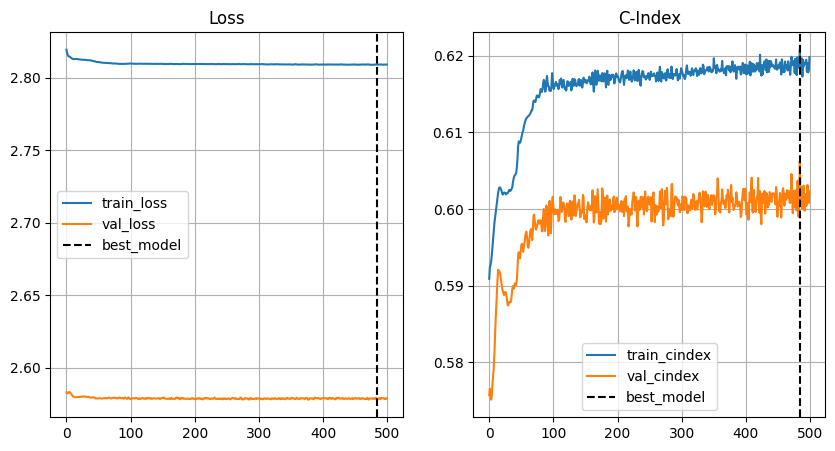

In [2]:
# Warm-up (reduces bugs)
config_warmup = deepcopy(config)
config_warmup['train_params']['steps'] = 20
log = ckan.train(train, val,do_symbolic_fit=False,do_prune_search=False,
                 duration_col=duration_col, event_col=event_col, **config_warmup['train_params'])

#turn on early stopping
config['train_params']['early_stopping'] = True
# Main training run
log = ckan.train(train, val,  duration_col=duration_col, event_col=event_col, **config['train_params'],prune_split=0.1)

ckan.predict(df_test)
ckan.save_ckpt(output_dir / 'model.pt')
fig = log.plot()
fig.savefig(output_dir / 'coxkan_training.png')

print(ckan.cindex(df_test))

CoxKAN - train: 0.617222 (0.616, 0.619), test: 0.623685 (0.621, 0.624)


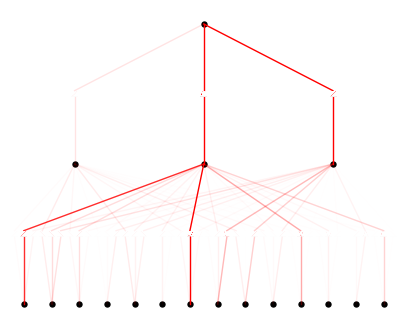

In [3]:
cindex_train = bootstrap_metric(ckan.cindex, df_train, N=100)['formatted']
cindex_test = bootstrap_metric(ckan.cindex, df_test, N=100)['formatted']

ckan_pre_str = f'CoxKAN - train: {cindex_train}, test: {cindex_test}'; print(ckan_pre_str)
results['CoxKAN']['Pre'] = {'train': cindex_train, 'test': cindex_test, 'n_params': coxkan_params}

fig = ckan.plot(beta=60, folder=f'./activations/{exp_name}_pre')
fig.savefig(output_dir / 'coxkan_pre.png')

In [4]:
# ckan = CoxKAN(seed=SEED, **config['init_params'])
# ckan.load_ckpt(output_dir / 'model.pt')
# ckan.predict(df_test)

In [5]:
ckan = ckan.prune_nodes(config['prune_threshold'])
_ = ckan.predict(df_test)
ckan.prune_edges(config['prune_threshold'], verbose=True)
_ = ckan.predict(df_test)


RuntimeError: Error(s) in loading state_dict for CoxKAN:
	size mismatch for biases.1.weight: copying a param with shape torch.Size([1]) from checkpoint, the shape in current model is torch.Size([1, 1]).

In [ ]:
fig = ckan.plot(beta=60, folder=f'./activations/{exp_name}_pruned')
fig.savefig(output_dir / 'coxkan_pruned.png')
cindex_train = bootstrap_metric(ckan.cindex, df_train, N=100)['formatted']
cindex_pruned = bootstrap_metric(ckan.cindex, df_test, N=100)['formatted']

ckan_pru_str = f'CoxKAN (pruned) - train: {cindex_train}, test: {cindex_pruned}'; print(ckan_pru_str)
results['CoxKAN']['Pruned'] = {'train': cindex_train, 'test': cindex_pruned}

In [ ]:
df_train_unnorm, df_test_unnorm = support.load(split=True)

l, i, j = 1, 1, 0
inputs = ckan.spline_preacts[l][:,j,i]
outputs = ckan.spline_postacts[l][:,j,i]
fig, ax = plt.subplots()
ax.scatter(inputs, outputs, marker='x', s=70, color='black')
ax.set_ylabel(r'Hazard Contribution $\Delta \theta$', fontsize=18)
ax.set_xlabel(r'Neuron $x_{1,2}$', fontsize=20)
fig.savefig(output_dir / f'({l},{i},{j}).png', bbox_inches='tight')

l, i, j = 0, 0, 1
inputs = df_test_unnorm[covariates[i]].values
outputs = ckan.spline_postacts[l][:,j,i]
fig, ax = plt.subplots()
ax.scatter(inputs, outputs, marker='x', s=70, color='black')
ax.set_xlabel('Age', fontsize=20)
ax.set_ylabel(r'Neuron Contribution $\Delta x_{1,2}$', fontsize=18)
fig.savefig(output_dir / f'({l},{i},{j}).png', bbox_inches='tight')

l, i, j = 0, 6, 1
inputs = df_test_unnorm[covariates[i]].values   
outputs = ckan.spline_postacts[l][:,j,i]
fig, ax = plt.subplots()
ax.scatter(inputs, outputs, marker='x', s=70, color='black')
# ax.set_xlabel('Cancer Status', fontsize=16)
ax.set_xticks([0,1,2])
ax.set_xticklabels(['0\nMetastasis', '1\nNo Cancer', '2\nCancer'], fontsize=18)
ax.set_ylabel(r'Neuron Contribution $\Delta x_{1,2}$', fontsize=20)
fig.savefig(output_dir / f'({l},{i},{j}).png', bbox_inches='tight')

In [ ]:
from matplotlib.gridspec import GridSpec

l, i, j = 1, 1, 0
inputs = ckan.spline_preacts[l][:,j,i]
outputs = ckan.spline_postacts[l][:,j,i]

# Create a figure with GridSpec
fig = plt.figure(figsize=(7, 8))
gs = GridSpec(2, 2, width_ratios=[1, 0.05], height_ratios=[1, 1], figure=fig)

# Create subplots
ax0 = fig.add_subplot(gs[0])
ax0.set_ylabel(r'Hazard Contribution $\Delta \theta$', fontsize=16)
ax0.set_xlabel(r'Neuron $x_{1,2}$', fontsize=16)
cax0 = fig.add_subplot(gs[1])

ax1 = fig.add_subplot(gs[2])
ax1.set_ylabel(r'Hazard Contribution $\Delta \theta$', fontsize=16)
ax1.set_xlabel(r'Neuron $x_{1,2}$', fontsize=16)
cax1 = fig.add_subplot(gs[3])

# Scatter plots
sc0 = ax0.scatter(inputs, outputs, c=df_test_unnorm['cancer'], cmap='viridis', alpha=0.5, marker='x', s=100)
sc1 = ax1.scatter(inputs, outputs, c=df_test_unnorm['age'], cmap='plasma', alpha=0.5, marker='x', s=100)

# Create a colorbar for the first subplot
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=0, vmax=2))
sm._A = []
cbar = plt.colorbar(sm, cax=cax0)
cbar.set_ticks([0,1,2])
cbar.set_ticklabels(['Metastasis', 'No Cancer', 'Cancer'], fontsize=12)

# Create a colorbar for the second subplot
sm = plt.cm.ScalarMappable(cmap='plasma', norm=plt.Normalize(vmin=0, vmax=100))
sm._A = []
cbar = plt.colorbar(sm, cax=cax1)
cbar.set_label('Age', fontsize=16)

plt.tight_layout()

fig.savefig(output_dir / f'colourplots.png')

no cancer - hazard is lower, and learly increasing with age.

metastatic cancer - hazard is high, increasing with age, but non-linearly.

cancer - hazard is high, initially decreases with age, then increases with age. 

### Symbolic fitting

There is no appropriate symbolic form for the interaction activation function. We perform normaly symbolic fitting on all others.

In [ ]:
from coxkan.utils import SYMBOLIC_LIB

### Symbolic Fitting

# Initial symbolic fitting (categorical covariates and linear activations)
# ckan.predict(df_test)
# for l in range(ckan.depth):
#     for i in range(ckan.width[l]):
#         for j in range(ckan.width[l+1]):
#             if ckan.symbolic_fun[l].mask[j, i] == 0:
#                 if l == 0 and hasattr(ckan, 'categorical_covariates') and ckan.covariates[i] in ckan.categorical_covariates:
#                     ckan.fix_symbolic(l,i,j,'categorical')
#                 else:
#                     # try linear fit (accept if R2 > 0.95)
#                     _, _, r2 = ckan.suggest_symbolic(l,i,j,lib=['x'], verbose=False)
#                     if r2 > 0.95:
#                         ckan.fix_symbolic(l,i,j,'x',verbose=False)
#                         print(f'Fixed ({l},{i},{j}) as linear')

_ = ckan.auto_symbolic(verbose=True)
_ = ckan.predict(df_test)
fig = ckan.plot()
fig.savefig(f'checkpoints/{exp_name}/coxkan_symbolic.png')
cindex_symbolic = bootstrap_metric(ckan.cindex, df_test, N=100)['formatted']
print(f"Symbolic: {cindex_symbolic}")
formula = ckan.symbolic_formula()[0][0]
formula

In [ ]:
# from coxkan.utils import SYMBOLIC_LIB
#
# lib = list(SYMBOLIC_LIB.keys()).copy()
# ckan.auto_symbolic(min_r2=0, lib=lib, verbose=True)

In [ ]:
# ckan.unfix_symbolic(1,1,0)
# ckan.unfix_symbolic(0,0,1)
# ckan.unfix_symbolic(0,6,1)

In [ ]:
ckan.cindex(df_test)

In [ ]:
fig = ckan.plot(beta=60, folder=f'./activations/{exp_name}_highlight')
fig.savefig(output_dir / 'coxkan_highlight.png', dpi=600)

In [ ]:
cindex_symbolic = bootstrap_metric(ckan.cindex, df_test, N=100)['formatted']
print(cindex_symbolic)

In [ ]:
ckan_sym_str = f'CoxKAN (symbolic) - test: {cindex_symbolic}'; print(ckan_sym_str)

results['CoxKAN']['Symbolic'] = {'test': cindex_symbolic}
with open(output_dir / 'results.pkl', 'wb') as f:
    pickle.dump(results, f)

# save c-index results to txt file too
with open(output_dir / 'cindex.txt', 'w') as f:
    f.write(ckan_pre_str + '\n')
    f.write(ckan_pru_str + '\n')
    f.write(ckan_sym_str + '\n')

In [ ]:
### Getting symbolic form for the rest of the model
ckan.fix_symbolic(1,1,0, '0')
ckan.fix_symbolic(0,0,1, '0')
ckan.fix_symbolic(0,6,1, '0')
formula = ckan.symbolic_formula(floating_digit=4)[0][0]
results['CoxKAN']['Symbolic']['formula'] = formula
with open(output_dir / 'results.pkl', 'wb') as f:
    pickle.dump(results, f)
formula

# Verifying observed trend with CoxPH

In [ ]:
from coxkan.datasets import support 
from lifelines import CoxPHFitter

df = support.load(split=False)

df_nocancer = df[df['cancer'] == 1]

cph = CoxPHFitter()
cph.fit(df_nocancer[['age', 'duration', 'event']], duration_col='duration', event_col='event')
print('No Cancer')
print(cph.summary['coef'].item())

df_metastatis = df[df['cancer'] == 0]

cph = CoxPHFitter()
cph.fit(df_metastatis[['age', 'duration', 'event']], duration_col='duration', event_col='event')
print('\nMetastatis')
print(cph.summary['coef'].item())

df_cancer = df[df['cancer'] == 2]

df_young = df_cancer[df_cancer['age'] < 60]

cph = CoxPHFitter()
cph.fit(df_young[['age', 'duration', 'event']], duration_col='duration', event_col='event')
print('\nYounger than 60, with cancer')
print(cph.summary['coef'].item())

df_old = df_cancer[df_cancer['age'] >= 60]

cph = CoxPHFitter()
cph.fit(df_old[['age', 'duration', 'event']], duration_col='duration', event_col='event')
print('\nOlder than 60, with cancer')
print(cph.summary['coef'].item())

with open(output_dir / 'cph_verify.txt', 'w') as f:
    f.write('No Cancer\n')
    f.write(str(cph.summary['coef'].item()) + '\n')
    f.write('\nMetastatis\n')
    f.write(str(cph.summary['coef'].item()) + '\n')
    f.write('\nYounger than 60, with cancer\n')
    f.write(str(cph.summary['coef'].item()) + '\n')
    f.write('\nOlder than 60, with cancer\n')
    f.write(str(cph.summary['coef'].item()) + '\n')

In [ ]:
cph = CoxPHFitter()
cph.fit(df_train, duration_col=duration_col, event_col=event_col)
def cph_cindex(df):
    return cph.score(df, scoring_method='concordance_index')
cindex_train = bootstrap_metric(cph_cindex, df_train, N=100)['formatted']
cindex_test = bootstrap_metric(cph_cindex, df_test, N=100)['formatted']
coxph_str = f'CoxPH - train: {cindex_train}, test: {cindex_test}'; print(coxph_str)
with open(output_dir / 'cindex.txt', 'a') as f:
    f.write(coxph_str + '\n')
results['CoxPH'] = {'train': cindex_train, 'test': cindex_test, 'summary': cph.summary}

with open(output_dir / 'results.pkl', 'wb') as f:
    pickle.dump(results, f)

### Visualizing some of the non-linear terms

In [ ]:
def set_red(ax):
    # Set the colors for the axes, labels, and tick marks
    ax.spines['bottom'].set_color('red')
    ax.spines['top'].set_color('red') 
    ax.spines['right'].set_color('red')
    ax.spines['left'].set_color('red')
    
    # ax.xaxis.label.set_color('red')
    # ax.yaxis.label.set_color('red')
    
    # ax.tick_params(axis='x', colors='red')
    # ax.tick_params(axis='y', colors='red')
    
    ax.title.set_color('red')

In [ ]:
ckan.predict(df_train)

fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# meanbp
l, i, j = 0, 7, 2
assert ckan.covariates[i] == 'meanbp'
inputs = df_train_unnorm[covariates[i]].values
outputs = ckan.spline_postacts[l][:,j,i]
axes[0].scatter(inputs, outputs, marker='x', s=70, color='red')
axes[0].set_yticks([])
axes[0].set_xlabel('Mean Blood Pressure', fontsize=20)
axes[0].set_ylabel(r'Hazard Contribution $\Delta \theta$', fontsize=20)
set_red(axes[0])

# heart rate
l, i, j = 0, 8, 2
assert ckan.covariates[i] == 'hr'
inputs = df_train_unnorm[covariates[i]].values
outputs = ckan.spline_postacts[l][:,j,i]
axes[1].scatter(inputs, outputs, marker='x', s=70, color='red')
axes[1].set_yticks([])
axes[1].set_xlabel('Heart Rate', fontsize=20)
set_red(axes[1])

# Respiration rate
l, i, j = 0, 9, 2
assert ckan.covariates[i] == 'rr'
inputs = df_train_unnorm[covariates[i]].values
outputs = ckan.spline_postacts[l][:,j,i]
axes[2].scatter(inputs, outputs, marker='x', s=70, color='red')
axes[2].set_yticks([])
axes[2].set_xlabel('Respiration Rate', fontsize=20)
set_red(axes[2])

# temp
l, i, j = 0, 10, 2
assert ckan.covariates[i] == 'temp'
inputs = df_train_unnorm[covariates[i]].values
outputs = ckan.spline_postacts[l][:,j,i]
axes[3].scatter(inputs, outputs, marker='x', s=70, color='red')
axes[3].set_yticks([])
axes[3].set_xlabel('Temperature', fontsize=20)
set_red(axes[3])

plt.tight_layout()
fig.savefig(output_dir / 'nonlinear-terms.png')

## Symbolic fitting the interaction term

In [ ]:
ckan = CoxKAN(seed=SEED, **config['init_params'])
ckan.load_ckpt(output_dir / 'model.pt')
_ = ckan.predict(df_test)

In [ ]:
from coxkan.utils import fit_params, SYMBOLIC_LIB

l, i, j = 1, 1, 0
x = ckan.spline_preacts[l][:,j,i]
y = ckan.spline_postacts[l][:,j,i]

# they are not ordered yet
rank = np.argsort(x)
x = x[rank]
y = y[rank]

############
# pykan's Auto-symbolic procedure
############
best_fn, _, r2 = ckan.suggest_symbolic(l, i, j, verbose=False)
func = SYMBOLIC_LIB[best_fn][0]
(a, b, c, d), r2 = fit_params(x, y, func, a_range=(-10,10), b_range=(-10,10))

y_pykan_pred = c*func(a*x+b)+d

In [ ]:
from coxkan.utils import add_symbolic 
import torch
import sympy
from pysr import PySRRegressor

############
# PySR symbolic fitting
############

default_pysr_params = dict(
    populations=30,
    model_selection="best",
)

# Learn equations
model = PySRRegressor(
    niterations=30,
    binary_operators=["+", "-", "*", "/"],
    unary_operators=['exp', 'sin', 'log', 'tanh', 'atan', 'cosh'],
    maxsize=15,
    procs=0,
    # multithreading=False,
    # deterministic=True,
    # random_state=42,
    **default_pysr_params,
)

model.fit(x.reshape(-1,1), y.reshape(-1,1))

sympy.simplify(model.sympy())

display(sympy.simplify(model.sympy()))

y_pysr_pred = model.predict(x.reshape(-1,1))

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(11, 5))

axes[0].scatter(x, y, marker='x', s=60, color='black', alpha=0.6, label='Activation fn')
axes[0].plot(x, y_pykan_pred, color='red', linestyle='--', linewidth=5, label='Symbolic fit')
axes[0].set_xlabel(r'Neuron $x_{1,2}$', fontsize=18)
axes[0].set_ylabel(r'Hazard Contribution $\Delta \theta$', fontsize=18)
axes[0].set_title('Default auto-symbolic', fontsize=20)
axes[0].legend(loc="upper left")

axes[1].scatter(x, y, marker='x', s=60, color='black', alpha=0.6, label='Activation fn')
axes[1].plot(x, y_pysr_pred, color='red', linestyle='--', linewidth=5, label='Symbolic fit')
axes[1].set_xlabel(r'Neuron $x_{1,2}$', fontsize=18)
axes[1].set_title('PySR symbolic regression', fontsize=20)
axes[1].set_yticks([])
axes[1].legend(loc="upper left")

plt.tight_layout()

fig.savefig(output_dir / 'symbolic-fitting.png', dpi=600)

In [ ]:
# # How we can add this symbolic function to the model
# from coxkan.utils import add_symbolic 
# import torch

# torch_fn = lambda x: torch.sin(x - (torch.sin(x + torch.arctan(x) - 0.7470143) - 0.2648517))
# sympy_fn = lambda x: sympy.sin(x - (sympy.sin(x + sympy.atan(x) - 0.7470143) - 0.2648517))

# add_symbolic('age_cancer_interaction', torch_fn, sympy_fn)

# r2 = ckan.fix_symbolic(1,1,0,'age_cancer_interaction')
# print(f'(1,1,0) Activation age_cancer_interaction fit with R^2: {r2}')
# r2 = ckan.fix_symbolic(0,0,1,'x')
# print(f'(0,0,1) Activation x fit with R^2: {r2}')
# r2 = ckan.fix_symbolic(0,6,1,'categorical')
# print(f'(0,6,1) Activation categorical fit with R^2: {r2}')

# ckan.cindex(df_test)